In [42]:
from synth_dim_model import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.integrate import solve_ivp

import pylab as plb
plb.rcParams['font.size'] = 12

In [43]:
N = 2
M = 2
mu =10
J = 2
V = 1

In [44]:
H0 = construct_initial_hamiltonian(N,M,mu)
Hf = construct_hamiltonian(N,M,J,V)

In [45]:
def construct_intermediate_hamiltonian(H0,Hf,s):
    return H0 * (1-s) + Hf * s

In [46]:
print(f"Initial Hamiltonian:\n {H0}\n")
print(f"Final Hamiltonian:\n {Hf}")

Initial Hamiltonian:
 [[-20.+0.j   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j -10.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j -10.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j   0.+0.j]]

Final Hamiltonian:
 [[ 0.+0.j -2.+0.j -2.+0.j  0.+0.j]
 [-2.+0.j  0.+0.j  1.+0.j -2.+0.j]
 [-2.+0.j  1.+0.j  0.+0.j -2.+0.j]
 [ 0.+0.j -2.+0.j -2.+0.j  0.+0.j]]


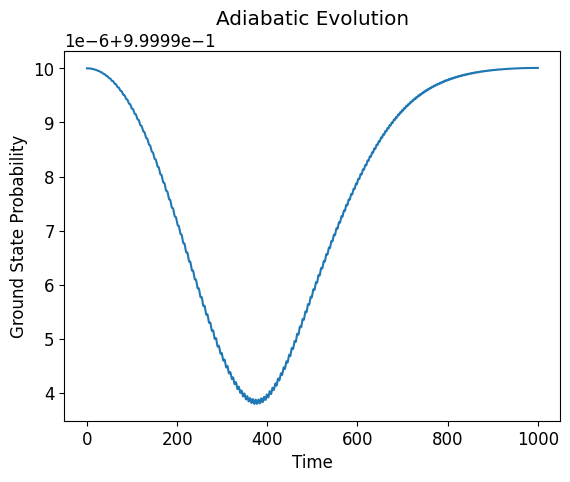

In [69]:
# Here's the full code with the necessary updates:

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Function to construct the initial Hamiltonian H0
def construct_initial_hamiltonian(N, M, mu):
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])

    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == 0:
                H[alpha, alpha] -= mu

    return H

# Function to construct the final Hamiltonian Hf
def construct_hamiltonian(N, M, J, V):
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    M_powers = np.array([M**i for i in range(N)])

    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])

    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(1, M):
                if state[j] == n:
                    new_state = state.copy()
                    new_state[j] = n - 1
                    beta = state_to_index(new_state)
                    H[alpha, beta] -= J
                    H[beta, alpha] -= J

    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            j = i + 1
            for n in range(1, M):
                if state[i] == n and state[j] == n - 1:
                    new_state = state.copy()
                    new_state[i], new_state[j] = n - 1, n
                    beta = state_to_index(new_state)
                    H[alpha, beta] += V
                    H[beta, alpha] += V

    return H

# Function to construct intermediate Hamiltonian H(s)
def construct_intermediate_hamiltonian(H0, Hf, s):
    return H0 * (1-s) + Hf * s

# Diagonalization function
def exact_diagonalize(H, verbose=False, check_reconstruction=False):
    if not np.allclose(np.conjugate(H.T), H):
        print("The matrix is not Hermitian. Please check the input matrix.")
        return None, None
    
    eigenvalues, V = np.linalg.eigh(H)
    D = np.diag(eigenvalues)
    
    if verbose:
        print("D Matrix = \n", D, "\n")
        print("V Matrix = \n", V, "\n")
        
    if check_reconstruction:
        reconstructed_H = V @ D @ np.conjugate(V.T)
        if np.allclose(reconstructed_H, H):
            print("Faithfully reconstructed the matrix.")
        else: 
            print("Reconstruction failed.")
    
    eigenvectors = [V[:, col_idx] for col_idx in range(V.shape[1])]
    
    return eigenvalues, eigenvectors

# Time-dependent Schrödinger equation with normalization
def normalized_tdse(t, psi, H0, Hf, t_total):
    psi = psi / np.linalg.norm(psi)  # Normalize the wavefunction
    s = np.sin((np.pi/2) * (t / t_total))**2  # Smooth interpolation
    H_s = construct_intermediate_hamiltonian(H0, Hf, s)
    return -1j * H_s.dot(psi)

# Function to evolve the system
def evolve_system(H0, Hf, psi0, t_total, t_points):
    t_eval = np.linspace(0, t_total, t_points)
    sol = solve_ivp(
        normalized_tdse, [0, t_total], psi0, t_eval=t_eval, 
        args=(H0, Hf, t_total), method='RK45',
        rtol=1e-10, atol=1e-12
    )
    return sol.t, sol.y

# Set parameters
N = 3
M = 2
mu = 1.0
J = 1.0
V = 0.5
t_total = 1000.0  # Increase to make evolution slower
t_points = 5000  # Higher resolution for better accuracy

# Construct initial and final Hamiltonians
H0 = construct_initial_hamiltonian(N, M, mu)
Hf = construct_hamiltonian(N, M, J, V)

# Ground state of H0
eigvals, eigvecs = np.linalg.eigh(H0)
psi0 = eigvecs[:, 0]
psi0 = psi0 / np.linalg.norm(psi0)  # Ensure normalization

# Evolve the system
t, psi_t = evolve_system(H0, Hf, psi0, t_total, t_points)

# Calculate ground state probabilities
ground_state_prob = np.zeros_like(t)
for i in range(len(t)):
    s = np.sin((np.pi/2) * (t[i] / t_total))**2
    H_s = construct_intermediate_hamiltonian(H0, Hf, s)
    _, eigvecs_s = exact_diagonalize(H_s)
    psi_ground_state_s = eigvecs_s[0]  # Ground state at time t
    ground_state_prob[i] = np.abs(np.dot(np.conjugate(psi_ground_state_s), psi_t[:, i]))**2

# Plot the results
plt.plot(t, ground_state_prob)
plt.xlabel('Time')
plt.ylabel('Ground State Probability')
plt.title('Adiabatic Evolution')
plt.show()

